## Closed-loop batch, constrained BO in botorch with qEI and qNEI

In this tutorial, we illustrate how to implement a simple Bayesian Optimization (BO) closed loop in botorch.

In general, we recommend for a relatively simple setup (like this one) to use Ax, since this will simplify your setup (including the amount of code you need to write) considerably. See the [Using botorch with Ax](../using_botorch_with_ax) tutorial.

However, you may want to do things that are not easily supported in Ax at this time (like running high-dimensional BO using a VAE+GP model that you jointly train on high-dimensional input data). If you find yourself in such a situation, you will need to write your own optimization loop, as we do in this tutorial.


We use the batch Expected Improvement (qEI) and batch Noisy Expected Improvement (qNEI) acquisition functions to optimize a constrained version of the synthetic Hartmann6 test function. The standard problem is

$$f(x) = -\sum_{i=1}^4 \alpha_i \exp \left( -\sum_{j=1}^6 A_{ij} (x_j - P_{ij})^2  \right)$$

over $x \in [0,1]^6$ (parameter values can be found in `botorch/test_functions/hartmann6.py`).

In real BO applications, the design $x$ can influence multiple metrics in unknown ways, and the decision-maker often wants to optimize one metric without sacrificing another. To illustrate this, we add a synthetic constarint fo the form $\|x\|_1 - 3 \le 0$. Both the objective and the constraint are observed with noise. 

Since botorch assumes a maximization problem, we will attempt to maximize $-f(x)$ to achieve $\max_{x} -f(x) = 3.32237$.

In [1]:
import torch
from botorch.test_functions.hartmann6 import neg_hartmann6
from botorch.models import SingleTaskGP
from botorch import fit_gpytorch_model
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float

#### Define a helper function that performs the essential BO step
The helper function below takes an acquisition function as an argument, optimizes it, and returns the batch $\{x_1, x_2, \ldots x_q\}$ along with the observed function values. For this example, we'll use a small batch of $q=3$. The function `joint_optimize` optimizes the $q$ points jointly. A simple initialization heuristic is used to select the 10 restart initial locations from a set of 50 random points. 

In [2]:
from botorch.optim import joint_optimize

BATCH_SIZE = 1
bounds = torch.tensor([[0.0]*6, [1.0]*6], device=device, dtype=dtype)

def optimize_acqf_and_get_observation(acq_func):
    """Optimizes the acquisition function, and returns a new candidate and a noisy observation."""
    
    candidates = joint_optimize(
        acq_function=acq_func,
        bounds=bounds,
        q=BATCH_SIZE,
        num_restarts=10,
        raw_samples=100,
        options={"maxiter": 75},
    )

    # observe new values 
    new_x = candidates.detach()
    new_obj = neg_hartmann6(new_x)
    return new_x, new_obj

def update_random_observations(best_random):
    """Simulates a random policy by taking a the current list of best values observed randomly,
    drawing a new random point, observing its value, and updating the list.
    """
    rand_x = torch.rand(BATCH_SIZE, 6)
    next_random_best = neg_hartmann6(rand_x).max().item()
    best_random.append(max(best_random[-1], next_random_best))       
    return best_random

#### Perform Bayesian Optimization loop with qNEI
The Bayesian optimization "loop" for a batch size of $q$ simply iterates the following steps:
1. given a surrogate model, choose a batch of points $\{x_1, x_2, \ldots x_q\}$
2. observe $f(x)$ for each $x$ in the batch 
3. update the surrogate model. 


Just for illustration purposes, we run three trials of `N_BATCH=20` iterations. The acquisition function is approximated using `MC_SAMPLES=500` samples.

In [3]:
from botorch import fit_gpytorch_model
from botorch.acquisition.entropy import MaxValueEntropySearch
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.acquisition.sampler import SobolQMCNormalSampler, IIDNormalSampler
import time

import warnings
warnings.filterwarnings('ignore')

N_TRIALS = 3
N_BATCH = 20
MC_SAMPLES = 256
CANDIDATE_SET_SIZE = 10000
verbose = True

best_observed_all_mves, best_observed_all_qei, best_random_all = [], [], []

# average over multiple trials
for trial in range(1, N_TRIALS + 1):
    
    print(f"\nTrial {trial:>2} of {N_TRIALS}", end="")
    best_observed_mves, best_observed_qei, best_random = [], [], []
    
    # call helper functions to generate initial training data and initialize model
    train_x = torch.rand(10, 6, device=device, dtype=dtype)
    train_obj = neg_hartmann6(train_x)
    
    train_x_mves = train_x.detach().clone()
    train_obj_mves = train_obj.detach().clone()
    model_mves = SingleTaskGP(train_X=train_x_mves, train_Y=train_obj_mves)
    mll_mves = ExactMarginalLogLikelihood(model_mves.likelihood, model_mves)
    fit_gpytorch_model(mll_mves)
    
    train_x_qei = train_x.detach().clone()
    train_obj_qei = train_obj.detach().clone()
    model_qei = SingleTaskGP(train_X=train_x_qei, train_Y=train_obj_qei)
    mll_qei = ExactMarginalLogLikelihood(model_qei.likelihood, model_qei)
    fit_gpytorch_model(mll_qei)

    best_observed_value = train_obj.max()
    best_observed_mves.append(best_observed_value.item())
    best_observed_qei.append(best_observed_value.item())
    best_random.append(best_observed_value.item())
    
    # run N_BATCH rounds of BayesOpt after the initial random batch
    for iteration in range(1, N_BATCH + 1):    
        t0 = time.time()
        
        # fit the models
        fit_gpytorch_model(mll_mves)
        
        # for best_f, we use the best observed noisy values as an approximation
        mves = MaxValueEntropySearch(
            model=model_mves, 
            bounds=bounds,
            candidate_set_size=CANDIDATE_SET_SIZE,
            sampler=IIDNormalSampler(num_samples=MC_SAMPLES)
        )
        qei = qExpectedImprovement(
            model=model_mves, 
            best_f=best_observed_value,
            sampler=SobolQMCNormalSampler(num_samples=MC_SAMPLES)
        )
        
        # optimize and get new observation
        new_x_mves, new_obj_mves = optimize_acqf_and_get_observation(mves)
        new_x_qei, new_obj_qei = optimize_acqf_and_get_observation(qei)
                
        # update training points
        train_x_mves = torch.cat((train_x_mves, new_x_mves.unsqueeze(-2)), dim=-2)
        train_obj_mves = torch.cat((train_obj_mves, new_obj_mves.unsqueeze(-1)), dim=-1)
        train_x_qei = torch.cat((train_x_qei, new_x_qei), dim=-2)
        train_obj_qei = torch.cat((train_obj_qei, new_obj_qei), dim=-1)

        # update progress
        best_random = update_random_observations(best_random)
        best_value_mves = neg_hartmann6(train_x_mves).max().item()
        best_observed_mves.append(best_value_mves)
        best_value_qei = neg_hartmann6(train_x_qei).max().item()
        best_observed_qei.append(best_value_qei)

        # reinitialize the models so they are ready for fitting on next iteration
        # use the current state dict to speed up fitting
        state_dict = model_mves.state_dict()
        model_mves = SingleTaskGP(train_X=train_x_mves, train_Y=train_obj_mves)
        model_mves.load_state_dict(state_dict)
        mll_mves = ExactMarginalLogLikelihood(model_mves.likelihood, model_mves)
        
        state_dict = model_qei.state_dict()
        model_qei = SingleTaskGP(train_X=train_x_qei, train_Y=train_obj_qei)
        model_qei.load_state_dict(state_dict)
        mll_qei = ExactMarginalLogLikelihood(model_qei.likelihood, model_qei)
        
        t1 = time.time()
        
        if verbose:
            print(
                f"\nBatch {iteration:>2}: best_value (random, MVES, QEI) = "
                f"({max(best_random):>4.2f}, {best_value_mves:>4.2f}, {best_value_qei:>4.2f}), "
                f"time = {t1-t0:>4.2f}.", end=""
            )
        else:
            print(".", end="")
   
    best_observed_all_mves.append(best_observed_mves)
    best_observed_all_qei.append(best_observed_qei)
    best_random_all.append(best_random)


Trial  1 of 3
Batch  1: best_value (random, MVES, QEI) = (2.73, 2.73, 2.73), time = 2.94.
Batch  2: best_value (random, MVES, QEI) = (2.73, 2.75, 2.75), time = 3.52.
Batch  3: best_value (random, MVES, QEI) = (2.73, 2.75, 2.75), time = 3.47.
Batch  4: best_value (random, MVES, QEI) = (2.73, 2.75, 2.75), time = 3.67.
Batch  5: best_value (random, MVES, QEI) = (2.73, 2.75, 2.75), time = 4.10.
Batch  6: best_value (random, MVES, QEI) = (2.73, 3.05, 3.00), time = 4.45.
Batch  7: best_value (random, MVES, QEI) = (2.73, 3.09, 3.08), time = 4.40.
Batch  8: best_value (random, MVES, QEI) = (2.73, 3.14, 3.13), time = 4.66.
Batch  9: best_value (random, MVES, QEI) = (2.73, 3.18, 3.14), time = 4.28.
Batch 10: best_value (random, MVES, QEI) = (2.73, 3.18, 3.19), time = 3.81.
Batch 11: best_value (random, MVES, QEI) = (2.73, 3.18, 3.19), time = 3.40.
Batch 12: best_value (random, MVES, QEI) = (2.73, 3.18, 3.19), time = 3.25.
Batch 13: best_value (random, MVES, QEI) = (2.73, 3.18, 3.19), time = 3.2

#### Plot the results

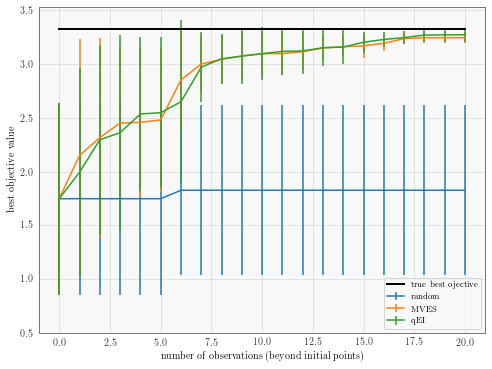

In [4]:
import math
import numpy as np
from botorch.test_functions.hartmann6 import GLOBAL_MAXIMUM

from matplotlib import pyplot as plt
%matplotlib inline

def ci(y):
    return 1.96 * y.std(axis=0) / math.sqrt(N_TRIALS)

iters = np.arange(N_BATCH + 1) * BATCH_SIZE
y_mves = np.asarray(best_observed_all_mves)
y_qei = np.asarray(best_observed_all_qei)
y_rnd = np.asarray(best_random_all)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.errorbar(iters, y_rnd.mean(axis=0), yerr=ci(y_rnd), label="random", linewidth=1.5)
ax.errorbar(iters, y_mves.mean(axis=0), yerr=ci(y_mves), label="MVES", linewidth=1.5)
ax.errorbar(iters, y_qei.mean(axis=0), yerr=ci(y_qei), label="qEI", linewidth=1.5)
plt.plot([0, N_BATCH * BATCH_SIZE], [GLOBAL_MAXIMUM] * 2, 'k', label="true best ojective", linewidth=2)
ax.set_ylim(bottom=0.5)
ax.set(xlabel='number of observations (beyond initial points)', ylabel='best objective value')
ax.legend(loc="lower right")